<a href="https://colab.research.google.com/github/vadimoz1032/LR-MLDL/blob/main/%D0%9B%D0%A0_%E2%84%964.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Подготовили студенты ИУ10-91, Грабчук Д.С., Конюхов М.В., Розанов В.В.

Датасет:
Набор данных для анализа и прогноза сердечного приступа. Цель модели -
0 = меньше вероятность сердечного приступа у пациента
1 = больше вероятность сердечного приступа у пациента

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,
                                     cross_val_score)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
 
#Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/heart.csv', sep=',')
df.head(3)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


Предобработка

In [ ]:
y = df['output'] # целевая переменная
X = df.drop('output', axis = 1) # признаки

In [ ]:
X.shape, y.shape

((303, 13), (303,))

Обучим дерево решений 

train_test_split Разделение массивов или матриц на случайные подмножества поездов и тестовых подмножеств

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=17)

first_tree = DecisionTreeClassifier(random_state=17)
# Обучаем дерево на тренировочных данных
first_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=17)

In [ ]:
y_pred =  first_tree.predict(X_test)
print('Точность измерений (тестовые данные): ', accuracy_score(y_true = y_test, y_pred = y_pred))

Точность измерений (тестовые данные):  0.7142857142857143


In [ ]:
cross_val_score(first_tree, X_train, y_train, cv=5)
# 5 раз дерево обучилось на наших данных

array([0.62790698, 0.74418605, 0.76190476, 0.71428571, 0.64285714])

In [ ]:
# возьмем среднее от них (по сути, это среднее качество на кросс-валидации)
np.mean(cross_val_score(first_tree, X_train, y_train, cv=5))

0.6982281284606866

без кросс валидации дерево решений показывает оценку лучше

# Случайный лес

Инициализируем стратифицированную разбивку нашего датасета для валидации

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Инициализируем наш классификатор с дефолтными параметрами
rfc = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)

In [ ]:
rfc.fit(X_train.values,y_train.values)
y_pred = rfc.predict(X_test)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
from sklearn import metrics
print("Accuracy score: {:.2f}%".format(metrics.accuracy_score(y_test, y_pred)*100))

Accuracy score: 82.42%


In [ ]:
# Обучаем на тренировочном датасете
results = cross_val_score(rfc, X.values, y, cv=skf)

# Оцениваем точность на тестовом датасете с помощью кросс валидации
print("CV accuracy score: {:.2f}%".format(results.mean()*100))

CV accuracy score: 81.52%


Достанем самые значимые признаки:

In [ ]:
rfc.feature_importances_

array([0.09438096, 0.03686515, 0.08877567, 0.08228349, 0.08529839,
       0.00745953, 0.01754771, 0.18320504, 0.04473254, 0.13067871,
       0.04878372, 0.10777722, 0.07221187])

In [ ]:
len(rfc.feature_importances_)

13

In [ ]:
col = [i for i in range(13)]
listValues = rfc.feature_importances_
myDict = {col[i]:listValues[i] for i in range(0, len(col), 1)} 
for key in myDict:
    print(key, '->', myDict[key])

0 -> 0.09438095798255393
1 -> 0.03686515097379312
2 -> 0.08877567216985245
3 -> 0.08228348636967314
4 -> 0.0852983873239448
5 -> 0.007459534500655968
6 -> 0.017547711973744346
7 -> 0.1832050442119464
8 -> 0.04473253873745113
9 -> 0.1306787056204017
10 -> 0.048783719974201355
11 -> 0.10777722036688007
12 -> 0.07221186979490159


In [ ]:
# если значения признака меньше 0.01 удалим его (считаем их близкими к нулю)
key_new = list()
for key in myDict:
    if myDict[key] < 0.01:
        key_new.append(key)
print(key_new) # номера столбцов которые мы будем удалять для метода ближайших соседей

[5]


Так как количество признаков не большое, только 1 из 13 признаков оказался не существенным. Уровень глюкозы в крови человека натощак, был удален. 

In [ ]:
df1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/heart.csv')
c = df.columns
for i in key_new:
     df1.drop([c[i]], axis = 1, inplace = True)
df1.info()
#видим что все поля числовые, и следовательно нет необходимости преобразовывать их

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   restecg   303 non-null    int64  
 6   thalachh  303 non-null    int64  
 7   exng      303 non-null    int64  
 8   oldpeak   303 non-null    float64
 9   slp       303 non-null    int64  
 10  caa       303 non-null    int64  
 11  thall     303 non-null    int64  
 12  output    303 non-null    int64  
dtypes: float64(1), int64(12)
memory usage: 30.9 KB


In [ ]:
y = df1['output'] # целевая переменная
X = df1.drop('output', axis = 1) # признаки
X.shape, y.shape

((303, 12), (303,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

Теперь посмотрим, как ведут себя кривые обучения при изменении основных параметров.

Начнем с количества деревьев:

In [ ]:
# Инициализируем валидацию
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
trees_grid = [5, 10, 15, 20, 30, 50, 75, 100]

# Обучаем на тренировочном датасете
for ntrees in trees_grid:
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1, oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X.values, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:554: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:554: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier w

Best accuracy on CV is 82.50% with 50 trees


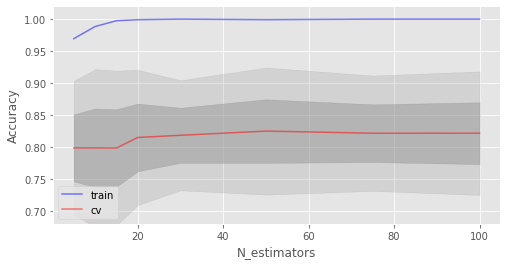

In [ ]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.68,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators");

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with

Best accuracy on CV is 82.84% with 5 max_depth


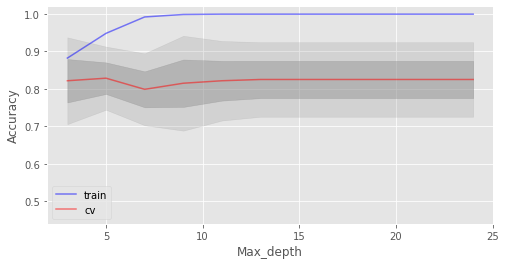

In [ ]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_depth_grid = [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

# Обучаем на тренировочном датасете
for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, oob_score=True, max_depth=max_depth)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_depth".format(max(test_acc.mean(axis=1))*100, 
                                                        max_depth_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.44,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_depth");

Параметр max_depth хорошо справляется с регуляризацией модели, и мы уже не так сильно переобучаемся.

Еще важный параметр min_samples_leaf, он так же выполняет функцию регуляризатора.

In [ ]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

# Обучаем на тренировочном датасете
for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, 
                                 oob_score=True, min_samples_leaf=min_samples_leaf)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} min_samples_leaf".format(max(test_acc.mean(axis=1))*100, 
                                                        min_samples_leaf_grid[np.argmax(test_acc.mean(axis=1))]))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with

Best accuracy on CV is 83.50% with 7 min_samples_leaf


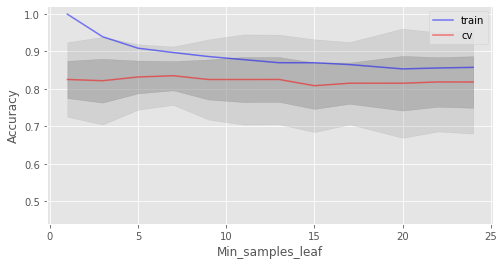

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.44,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Min_samples_leaf");

В данном случае мы не выигрываем в точности на валидации, но зато можем сильно уменьшить переобучение

Рассмотрим такой параметр как max_features. Для задач классификации по умолчанию используется √n , где n — число признаков. Давайте проверим, оптимально ли в нашем случае использовать 4 признаков или нет.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with

Best accuracy on CV is 81.51% with 2 max_features


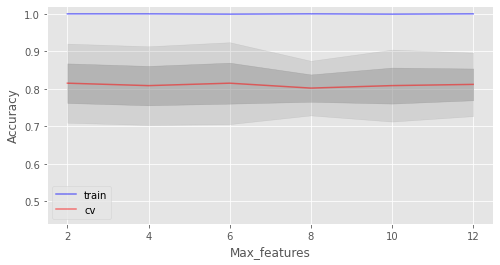

In [ ]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_features_grid = [2, 4, 6, 8, 10, 12]

# Обучаем на тренировочном датасете
for max_features in max_features_grid:
    rfc = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, 
                                 oob_score=True, max_features=max_features)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_features".format(max(test_acc.mean(axis=1))*100, 
                                                        max_features_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_features_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.44,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_features");

В нашем случае оптимальное число признаков — 2, именно с таким значением достигается наилучший результат.

Мы рассмотрели, как ведут себя кривые обучения в зависимости от изменения основных параметров.Сейчас с помощью GridSearch мы найдем оптимальные параметры для нашей задачи.

---



In [ ]:
# Сделаем инициализацию параметров, по которым хотим сделать полный перебор
parameters = {'max_features': [2, 5, 8, 11], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5,10,15,20]}
rfc = RandomForestClassifier(n_estimators=50, random_state=42, 
                             n_jobs=-1, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X, y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(n_estimators=50, n_jobs=-1,
                                              oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [2, 5, 8, 11],
                         'min_samples_leaf': [1, 3, 5, 7]},
             verbose=1)

In [ ]:
gcv.best_estimator_, gcv.best_score_

(RandomForestClassifier(max_depth=10, max_features=2, min_samples_leaf=3,
                        n_estimators=50, n_jobs=-1, oob_score=True,
                        random_state=42), 0.8480874316939891)

Лучшая точность, который мы смогли достичь с помощью перебора параметров — 84.81% при: 'max_depth': 20, 'max_features': 2, 'min_samples_leaf': 3.

# Градиентный бустинг

In [ ]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
!pip install catboost


In [ ]:
%%time

from catboost import CatBoostRegressor
import numpy as np

scores = np.ndarray([10, 10])
for i, n_trees in enumerate(np.linspace(1, 100, 10)):
    for j, depth in enumerate(np.arange(2, 12)):
        p = CatBoostRegressor(n_estimators=n_trees, max_depth=depth).fit(X_train, y_train).predict(X_test)
        scores[i, j] = mean_squared_error(y_test, p)

Выходные данные были обрезаны до нескольких последних строк (5000).
1:	learn: 0.3918703	total: 759us	remaining: 7.97ms
2:	learn: 0.3633955	total: 1.2ms	remaining: 8.01ms
3:	learn: 0.3561151	total: 1.62ms	remaining: 7.7ms
4:	learn: 0.3458532	total: 2.18ms	remaining: 7.86ms
5:	learn: 0.3372773	total: 2.7ms	remaining: 7.64ms
6:	learn: 0.3318479	total: 3.26ms	remaining: 7.45ms
7:	learn: 0.3270838	total: 3.73ms	remaining: 6.99ms
8:	learn: 0.3229978	total: 4.15ms	remaining: 6.46ms
9:	learn: 0.3216233	total: 4.56ms	remaining: 5.93ms
10:	learn: 0.3212316	total: 4.98ms	remaining: 5.43ms
11:	learn: 0.3198992	total: 5.39ms	remaining: 4.94ms
12:	learn: 0.3159026	total: 6.05ms	remaining: 4.66ms
13:	learn: 0.3114630	total: 6.51ms	remaining: 4.18ms
14:	learn: 0.3089265	total: 6.9ms	remaining: 3.68ms
15:	learn: 0.3078810	total: 7.31ms	remaining: 3.2ms
16:	learn: 0.3024458	total: 7.81ms	remaining: 2.76ms
17:	learn: 0.2990906	total: 8.28ms	remaining: 2.3ms
18:	learn: 0.2976923	total: 8.73ms	remaining: 1

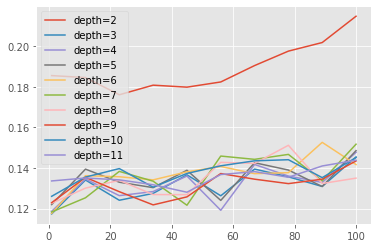

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

for i in range(scores.shape[0]):
    plt.plot(np.linspace(1, 100, 10), scores[i], label='depth=' + str(np.arange(2, 12)[i]))
plt.legend()

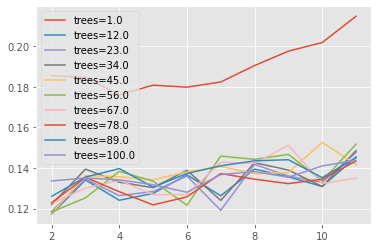

In [ ]:
for i in range(scores.shape[1]):
    plt.plot(np.arange(2, 12), scores[i], label='trees=' + str(np.linspace(1, 100, 10)[i]))
plt.legend()

Сравним с лесом

In [ ]:
%%time

from sklearn.ensemble import RandomForestRegressor

linear_preds = RandomForestRegressor(max_depth = 10, max_features = 2, min_samples_leaf = 3).fit(X_train, y_train).predict(X_test)
res = mean_squared_error(y_test, linear_preds) ** 0.5
print(res)

0.3561143837520075
CPU times: user 167 ms, sys: 0 ns, total: 167 ms
Wall time: 170 ms


Итог: случайный лес отработал хуже градиентного бустинга